# Phase Proportions over Time

The goal of this script is to create a stacked plot of each of the phases from their time of creation. This includes invalid taggings, transitional taggings, and unknown taggings. This data is presented to better understand how patients travel through the Cancer Journey Framework by Jacobs et al.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
from phase import *
import pandas as panda
import numpy as np
import subprocess
from tqdm import tqdm
import matplotlib.pyplot as mpl
import matplotlib.cm as cm
import matplotlib
import pylab as pl

from data_tools import get_first_journal_ts_from

In [4]:
sys.path.append("../../annotation_data")
vw_working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/phases/vw"

In [5]:
all_predictions_filepath = os.path.join(vw_working_dir, "vw_all_preds.pkl")
pred_df = panda.read_pickle(all_predictions_filepath)

## Data Manipulation

In [6]:
#Produce a manual timestamp as time_buckets since site creation. In this case, it is days.
results =  []
ms_in_days  = 1000 * 60 * 60 * 24     # ms  * s  * hr * dy
for site_id, site_preds in tqdm(pred_df.groupby(by='site_id', sort=False)):
    this = (site_preds['created_at'] - get_first_journal_ts_from(site_id)) / ms_in_days
    results = np.append(results, this)
pred_df['man_ts'] = results

100%|██████████| 4977/4977 [00:27<00:00, 178.20it/s]


In [7]:
#Here is the enumeration and order of treatment classes, along with some variables for dynamic data compilation
friendly_names = ["Pre-treatment", "Treatment", "End Of Life", "No Evidence of Disease", "Transition", "Unknown", "Invalid"]
phase_names = ["pretreatment", "treatment", "end_of_life", "cured", "transition", "unknown", "invalid"]
phase_codes = ["PT", "T", "EOL", "NED", "TRN", "NA", "INV"]
num_buckets = 1000
num_phases = len(phase_names)
phase_counts = np.zeros((num_phases, num_buckets))

In [8]:
#Construct a discrete table of phase counts for each time bucket.
for index, row in tqdm(pred_df.iterrows()):
    time_in_weeks = int(row['man_ts'])
    if time_in_weeks < num_buckets:
        if len(row['phases']) > 1:
            # Case: Valid transitions
            if (row['phases'] == ['pretreatment', 'treatment'] 
                or row['phases'] == ['treatment', 'end_of_life'] 
                or row['phases'] == ['treatment', 'cured']):
                phase_counts[phase_names.index("transition"), time_in_weeks] += 1
            # Case: Invalid transitions
            else:
                phase_counts[phase_names.index("invalid"), time_in_weeks] += 1
        # Case: Singleton tags
        else:
            for phase in row['phases']:
                phase_index = phase_names.index(phase)
                phase_counts[phase_index, time_in_weeks] += 1
table = panda.DataFrame(phase_counts, index=phase_codes)
table = table.T

158109it [00:26, 5939.86it/s]


## Data Visualization

In [9]:
#Set some visualization constants
mpl.rcParams['figure.figsize'] = [6.975, 3.3]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['font.size'] = 7
roll_window = 30

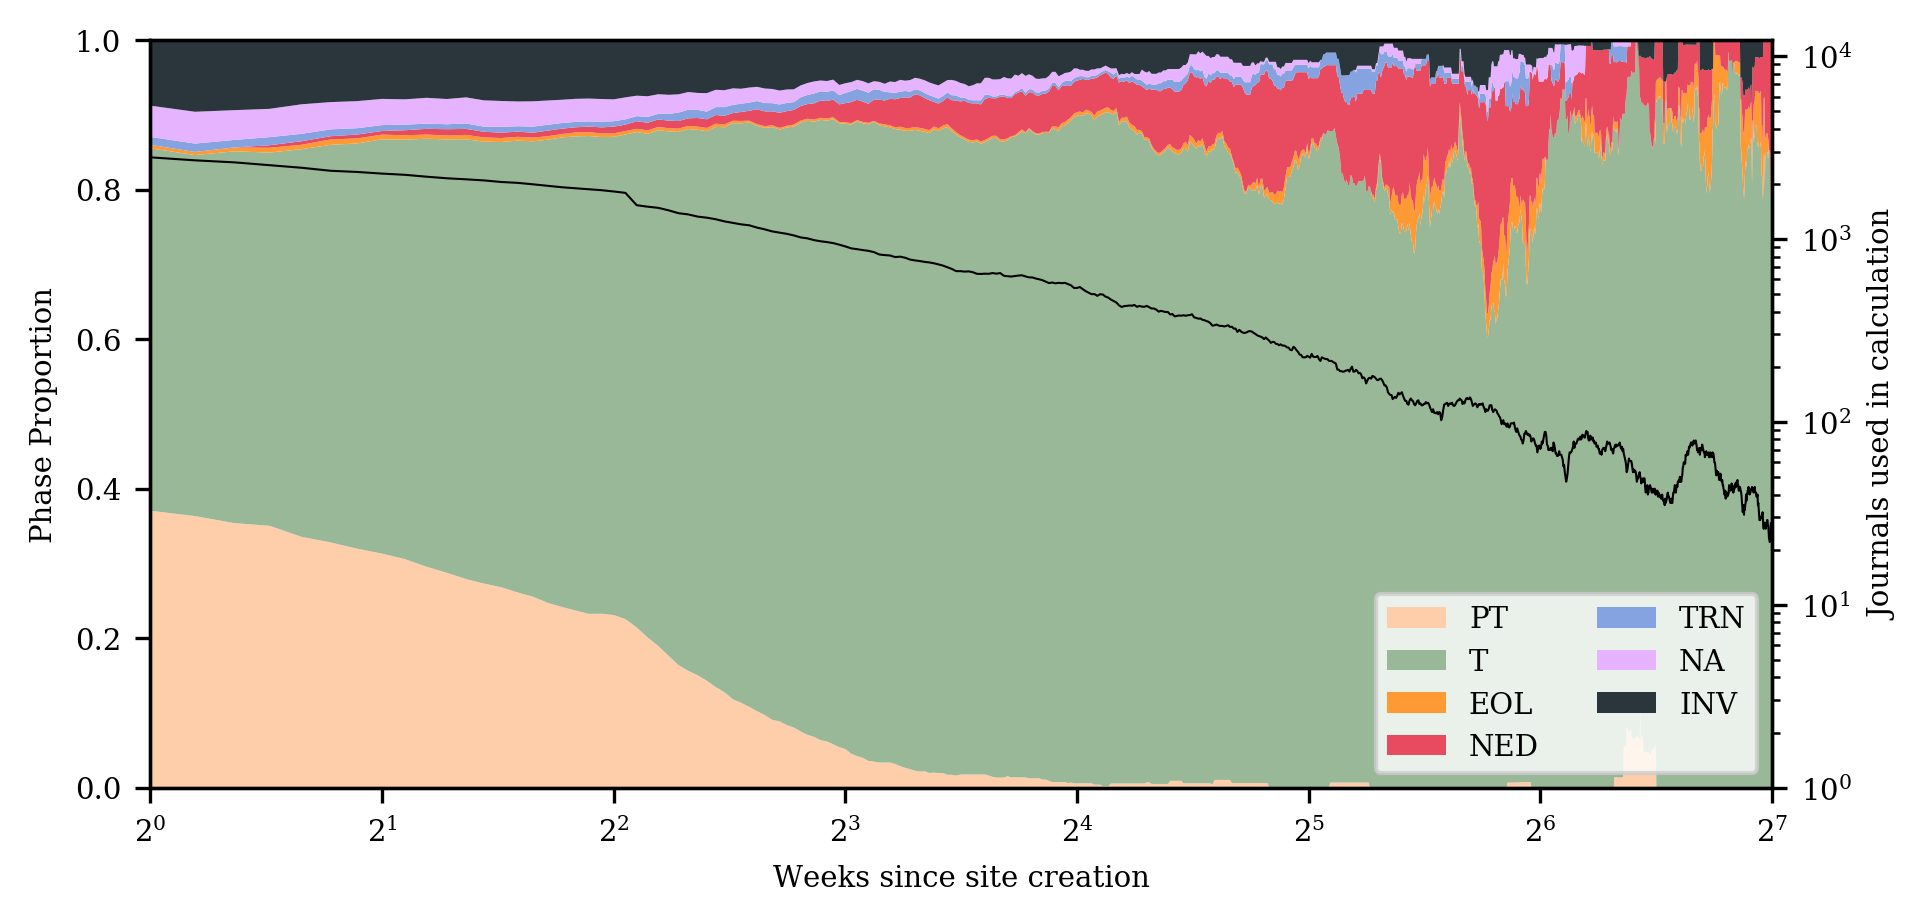

In [15]:
# List comprehension since scale is in weeks... simply the range module if in days
t = [i/7 for i in range(0, num_buckets)]

# Coloration shtuff... stackplots dont support colormaps directly, gotta finesse it
cmap = matplotlib.cm.get_cmap('Set2')
palette = ['#FECEAB', '#99B898', '#FF9933', '#E84A5F', '#85A3E0', '#E6B3FF', '#2A363B'] 
#palette = [cmap(i/num_phases) for i in range(1,num_phases)]

# Construct a sum-of-journals log-series and a proportional phase count series
data_sums = table.sum(axis=1)
data_perc = table.divide(data_sums, axis=0)

# Apply rolling of roll_window size to the data for a more smooth interpretations
data_perc = data_perc.rolling(min_periods=1, window=roll_window).mean()
data_sums = data_sums.rolling(min_periods=1, window=roll_window).mean()

# Comment out if scale is in days
data_sums.index = data_sums.index/7

# Draw the graphs
fig, ax = mpl.subplots()
ax.stackplot(t, data_perc.T, colors=palette, labels=phase_codes)
ax.legend(ncol=2, loc='lower right')
ax.set_ylim(top=1)
ax.set_xscale('log', basex=2)
ax.set_xlim(left=1, right=np.power(2,7))
ax.set_ylabel("Phase Proportion")
ax.set_xlabel("Weeks since site creation")

ax2 = ax.twinx()
ax2.plot(data_sums * roll_window, color='black', linewidth = .5)
ax2.set_yscale('log')
ax2.set_ylabel('Journals used in calculation')
ax2.tick_params(axis='y')
ax2.set_ylim(bottom=1)

mpl.margins(0,0)
fig.savefig(fname="withadjustments.pdf", dpi=300, bbox_inches='tight', pad_inches = 0)